In [1]:
import json
import pandas as pd
from IPython.display import display, Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

### Load data

In [2]:
def load_data(path: str):
    with open(path) as file:
        json_data = json.load(file)
    df = pd.DataFrame(json_data)

    if "_id" in df.columns:
        df = df.drop(columns="_id")

    return df

unobfuscated_unoptimized = load_data("./data/unoptimized/unobfuscated.json")
unobfuscated_optimized = load_data("./data/optimized/unobfuscated.json")

tigress_unoptimized = load_data("./data/unoptimized/tigress.json")
tigress_optimized = load_data("./data/optimized/tigress.json")

llvm_unoptimized = load_data("./data/unoptimized/llvm.json")
llvm_optimized = load_data("./data/optimized/llvm.json")

wasm_mutate_unoptimized = load_data("./data/unoptimized/wasm-mutate.json")
wasm_mutate_optimized = load_data("./data/optimized/wasm-mutate.json")

### Pre-process data

In [3]:
transformation_label_map = {
    "flatten": "Flattening",
    "randomfuns": "Random Functions",
    "encodearithmetic": "Encode Arithmetic",
    "encodeliterals": "Encode Literals",
    "split": "Function Splitting",
    "virtualize": "Virtualization",
    "antitaintanalysis": "Anti Taint Analysis",
    "antialiasanalysis": "Anti Alias Analysis"
}

# Create a new column 'transformation_label' based on the 'transformation' column values
tigress_unoptimized['transformation_label'] = tigress_unoptimized['transformation'].map(transformation_label_map)
tigress_optimized['transformation_label'] = tigress_optimized['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'transformation' column values
transformation_label_map = {
    "cffobf": "Control Flow Flattening",
    "bcfobf": "Bogus Control Flow",
    "constenc": "Constants Encryption",
    "strcry": "String Encryption",
    "splitobf": "Basic Block Splitting",
    "indibran": "Indirect Branches",
    "subobf": "Substitute Instruction",
    "funcwra": "Function Wrapper"
}
llvm_unoptimized['transformation_label'] = llvm_unoptimized['transformation'].map(transformation_label_map)
llvm_optimized['transformation_label'] = llvm_optimized['transformation'].map(transformation_label_map)

# Create a new column 'transformation_label' based on the 'mutator' column values
wasm_mutate_unoptimized['transformation'] = wasm_mutate_unoptimized['mutator']
wasm_mutate_optimized['transformation'] = wasm_mutate_optimized['mutator']
transformation_label_map = {
    "AddCustomSectionMutator": "Add Custom Section",
    "PeepholeMutator": "Peephole",
    "CodemotionMutator": "Code Motion",
    "AddTypeMutator": "Add Type",
    "AddFunctionMutator": "Add Function",
    "RemoveSection": "Remove Section",
    "RemoveItemMutator": "Remove Item",
    "ReorderCustomSectionMutator": "Reorder Custom Section", 
    "CustomSectionMutator": "Custom Section"
}
wasm_mutate_unoptimized['transformation_label'] = wasm_mutate_unoptimized['transformation'].map(transformation_label_map)
wasm_mutate_optimized['transformation_label'] = wasm_mutate_optimized['transformation'].map(transformation_label_map)

### Configure Seaborn

In [4]:
sns.set_theme(
    style="whitegrid",
    context="paper",
    font_scale=1.2,
    rc = {
      "figure.figsize": (10, 6),
      "errorbar.capsize": 0.05,
      "xtick.color": "#646464",
      "ytick.color": "#646464",
      "legend.loc": "best",
      "font.family": "Ubuntu",
    }
)

palette = "tab20"
edgecolor = "#646464"
errwidth = 1.8
capsize = 0.05

blues = sns.color_palette("Blues", n_colors= 1)
greens = sns.color_palette("Greens", n_colors=1)
reds = sns.color_palette("Reds", n_colors=1)

bgr_palette = blues + greens + reds

#### Distance plot by transformation

In [5]:
def plot_distance_by_transformation(df, xlabel, palette=None, path=None):
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['distance'].mean().reset_index()
    
    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('distance', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    sorted_df = df.sort_values('transformation_label')

    sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y='distance', 
                hue='method',
                dodge=False,
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel(xlabel)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper right')

    plt.ylim(0, 350000)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

/tmp/ipykernel_10595/943971472.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'


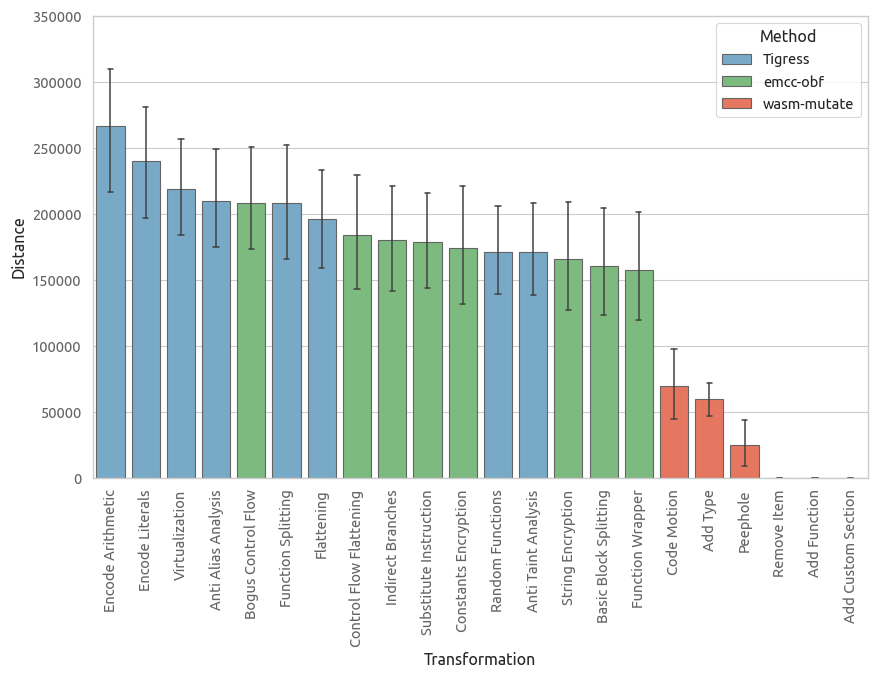

In [6]:
# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] == -1]

# Add a 'method' column to each dataframe
tigress_unoptimized['method'] = 'Tigress'
llvm_unoptimized['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_unoptimized, llvm_unoptimized, filtered_wasm_mutate_data], ignore_index=True)
plot_distance_by_transformation(df, xlabel='Transformation', palette=bgr_palette)

/tmp/ipykernel_10595/1184585551.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_wasm_mutate_data['method'] = 'wasm-mutate'


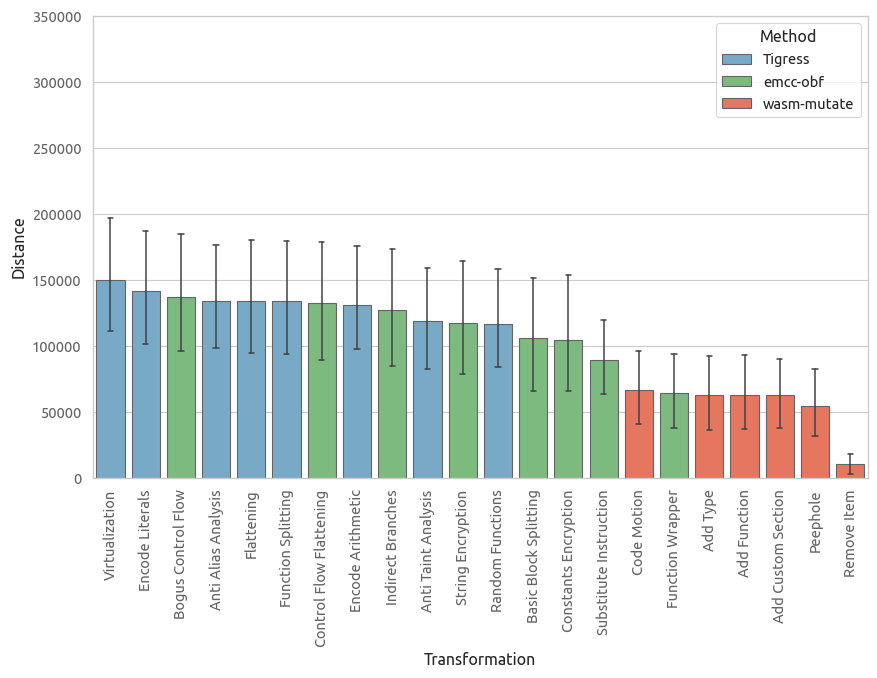

In [7]:
# filter wasm-mutate data
filtered_wasm_mutate_data = wasm_mutate_optimized[wasm_mutate_optimized['iteration'] == -1]

# Add a 'method' column to each dataframe
tigress_optimized['method'] = 'Tigress'
llvm_optimized['method'] = 'emcc-obf'
filtered_wasm_mutate_data['method'] = 'wasm-mutate'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_optimized, llvm_optimized, filtered_wasm_mutate_data], ignore_index=True)
plot_distance_by_transformation(df, xlabel='Transformation', palette=bgr_palette)

/tmp/ipykernel_10595/2712823712.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasm_mutate_optimized_filtered['method'] = 'wasm-mutate'
/tmp/ipykernel_10595/2712823712.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wasm_mutate_unoptimized_filtered['method'] = 'wasm-mutate'
/tmp/ipykernel_10595/2712823712.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

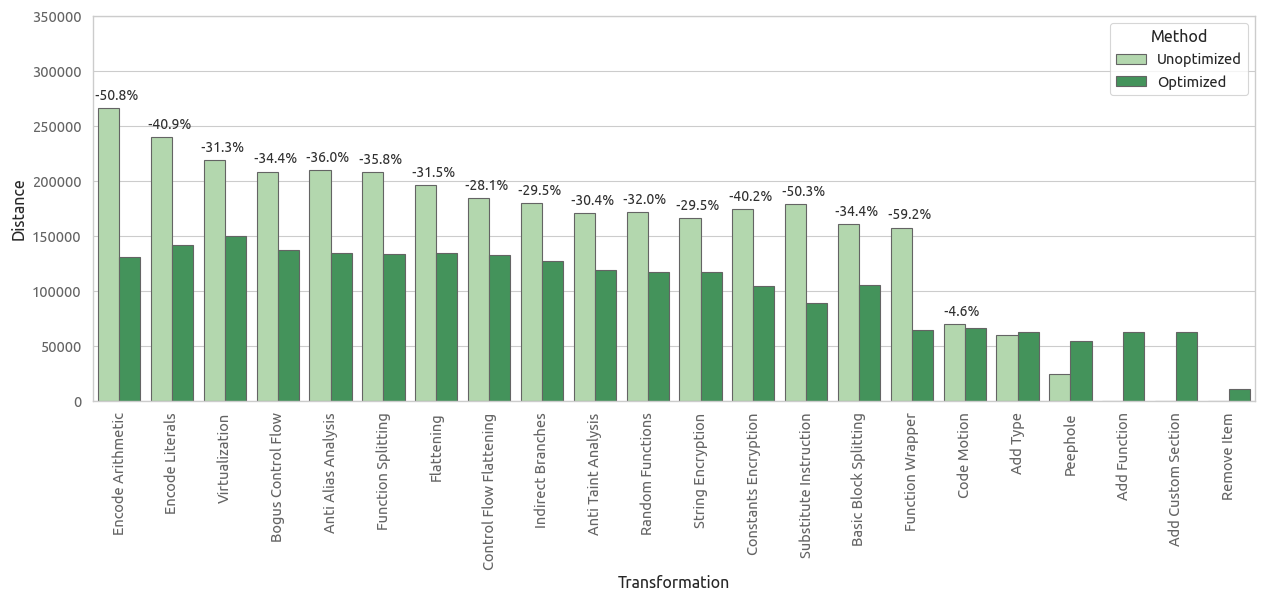

In [8]:
def plot_distance_by_transformation(df, xlabel, palette=None, path=None):
    plt.figure(figsize=(15,5))
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['distance'].mean().reset_index()

    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('distance', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    sorted_df = df.sort_values('transformation_label')

    ax = sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y='distance', 
                hue='optimization',
                #dodge=False,
                errorbar=None, 
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    bar_diffs = ((ax.containers[1].datavalues - ax.containers[0].datavalues) / ax.containers[0].datavalues) * 100
    formatted_diffs = [f'     {diff:.1f}%' for diff in bar_diffs]

    formatted_diffs[-1] = ''
    formatted_diffs[-2] = ''
    formatted_diffs[-3] = ''
    formatted_diffs[-4] = ''
    formatted_diffs[-5] = ''

    ax.bar_label(ax.containers[0], labels=formatted_diffs, padding=4, size=10, color="#303030", fmt='%.1f')
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel(xlabel)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper right')

    plt.ylim(0, 350000)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# filter wasm-mutate data
wasm_mutate_optimized_filtered = wasm_mutate_optimized[wasm_mutate_optimized['iteration'] == -1]

# Add a 'method' column to each dataframe
tigress_optimized['method'] = 'Tigress'
llvm_optimized['method'] = 'emcc-obf'
wasm_mutate_optimized_filtered['method'] = 'wasm-mutate'

# Add a 'method' column to each dataframe
tigress_unoptimized['method'] = 'Tigress'
llvm_unoptimized['method'] = 'emcc-obf'
wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] == -1]
wasm_mutate_unoptimized_filtered['method'] = 'wasm-mutate'

# Add 'optimization' column to each dataframe
tigress_optimized['optimization'] = 'Optimized'
llvm_optimized['optimization'] = 'Optimized'
wasm_mutate_optimized_filtered['optimization'] = 'Optimized'

tigress_unoptimized['optimization'] = 'Unoptimized'
llvm_unoptimized['optimization'] = 'Unoptimized'
wasm_mutate_unoptimized_filtered['optimization'] = 'Unoptimized'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df_combined = pd.concat([tigress_optimized, llvm_optimized, wasm_mutate_optimized_filtered,
                         tigress_unoptimized, llvm_unoptimized, wasm_mutate_unoptimized_filtered], ignore_index=True)

plot_distance_by_transformation(df_combined, xlabel='Transformation', palette="Greens", path='test_combined.png')

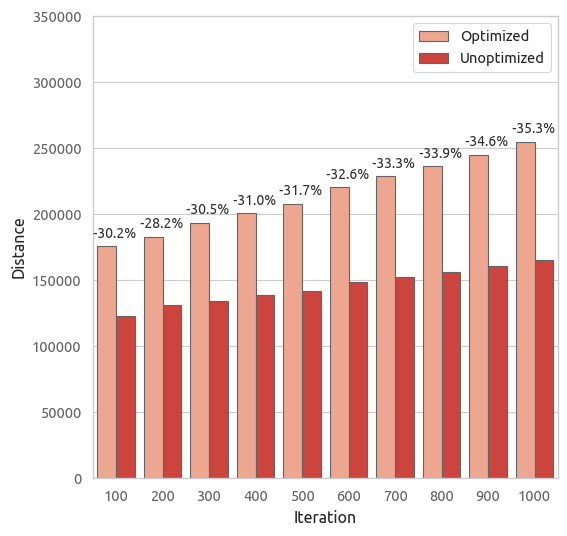

In [9]:
def plot_distance_by_iteration(df, palette=palette, path=None):
    plt.figure(figsize=(6,6))
    ax = sns.barplot(data=df, 
                x='iteration', 
                y='distance', 
                hue='optimization',
                palette=palette, 
                errorbar=None, 
                edgecolor=edgecolor
                )
    
    bar_diffs = ((ax.containers[1].datavalues - ax.containers[0].datavalues) / ax.containers[0].datavalues) * 100
    formatted_diffs = [f'     {diff:.1f}%' for diff in bar_diffs]

    ax.bar_label(ax.containers[0], labels=formatted_diffs, padding=4, size=10, color="#303030", fmt='%.1f')
    
    # Axis labels
    plt.ylabel('Distance')
    plt.xlabel('Iteration')

    # Capitalize the first letter of the entries in the legend
    plt.legend(loc='upper right')

    plt.ylim(0, 350000)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()



# filter wasm-mutate data
wasm_mutate_optimized_filtered = wasm_mutate_optimized[wasm_mutate_optimized['iteration'] != -1]
wasm_mutate_optimized_filtered = wasm_mutate_optimized_filtered[wasm_mutate_optimized_filtered['distance'].notnull()]

# filter wasm-mutate data
wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] != -1]
wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized_filtered[wasm_mutate_unoptimized_filtered['distance'].notnull()]

wasm_mutate_unoptimized_filtered['optimization'] = 'Optimized'
wasm_mutate_optimized_filtered['optimization'] = 'Unoptimized'

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([ wasm_mutate_unoptimized_filtered, wasm_mutate_optimized_filtered], ignore_index=True)

red = sns.color_palette("Reds", n_colors=1)
plot_distance_by_iteration(df, palette="Reds", path='./plots/effectiveness/distance-mutate.pdf')

#### V8 optimization plots

In [10]:
def get_liftoff_and_turbofan_sizes(df):
    df['liftoff_size'] = df['v8'].apply(lambda x: x['liftoff_size'])
    df['turbofan_size'] = df['v8'].apply(lambda x: x['turbofan_size'])
    return df 

unobfuscated_unoptimized = get_liftoff_and_turbofan_sizes(unobfuscated_unoptimized)
tigress_unoptimized = get_liftoff_and_turbofan_sizes(tigress_unoptimized)
llvm_unoptimized = get_liftoff_and_turbofan_sizes(llvm_unoptimized)

wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] == -1]
wasm_mutate_unoptimized_filtered = get_liftoff_and_turbofan_sizes(wasm_mutate_unoptimized_filtered)

/tmp/ipykernel_10595/4170217346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['liftoff_size'] = df['v8'].apply(lambda x: x['liftoff_size'])
/tmp/ipykernel_10595/4170217346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['turbofan_size'] = df['v8'].apply(lambda x: x['turbofan_size'])


In [11]:
def compute_relative_sizes(df, unobfuscated_unoptimized):

    # Function to lookup values in the unobfuscated_unoptimized DataFrame
    def lookup_unobfuscated_value(file, column):
        return unobfuscated_unoptimized.loc[unobfuscated_unoptimized['file'] == file, column].values[0]

    # Calculate the relative liftoff_size and relative_turbofan_size
    df['relative_liftoff_size'] = df.apply(lambda row: row['liftoff_size'] / lookup_unobfuscated_value(row['unobfuscated_file'], 'liftoff_size'), axis=1)
    df['relative_turbofan_size'] = df.apply(lambda row: row['turbofan_size'] / lookup_unobfuscated_value(row['unobfuscated_file'], 'turbofan_size'), axis=1)

    # Return the modified DataFrame with the new columns
    return df


tigress_unoptimized = compute_relative_sizes(tigress_unoptimized, unobfuscated_unoptimized)
llvm_unoptimized = compute_relative_sizes(llvm_unoptimized, unobfuscated_unoptimized)
wasm_mutate_unoptimized_filtered = compute_relative_sizes(wasm_mutate_unoptimized_filtered, unobfuscated_unoptimized)

/tmp/ipykernel_10595/1748718249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_liftoff_size'] = df.apply(lambda row: row['liftoff_size'] / lookup_unobfuscated_value(row['unobfuscated_file'], 'liftoff_size'), axis=1)
/tmp/ipykernel_10595/1748718249.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_turbofan_size'] = df.apply(lambda row: row['turbofan_size'] / lookup_unobfuscated_value(row['unobfuscated_file'], 'turbofan_size'), axis=1)


In [12]:
def compute_instruction_increase(df, unobfuscated_unoptimized):

    # Function to lookup values in the unobfuscated_unoptimized DataFrame
    def lookup_unobfuscated_value(file, column):
        return unobfuscated_unoptimized.loc[unobfuscated_unoptimized['file'] == file, column].values[0]

    # Calculate the relative liftoff_size and relative_turbofan_size
    df['liftoff_increase'] = df.apply(lambda row: row['liftoff_size'] - lookup_unobfuscated_value(row['unobfuscated_file'], 'liftoff_size'), axis=1)
    df['turbofan_increase'] = df.apply(lambda row: row['turbofan_size'] - lookup_unobfuscated_value(row['unobfuscated_file'], 'turbofan_size'), axis=1)

    # Return the modified DataFrame with the new columns
    return df

tigress_unoptimized = compute_instruction_increase(tigress_unoptimized, unobfuscated_unoptimized)
llvm_unoptimized = compute_instruction_increase(llvm_unoptimized, unobfuscated_unoptimized)
wasm_mutate_unoptimized_filtered = compute_instruction_increase(wasm_mutate_unoptimized_filtered, unobfuscated_unoptimized)

/tmp/ipykernel_10595/2248387090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['liftoff_increase'] = df.apply(lambda row: row['liftoff_size'] - lookup_unobfuscated_value(row['unobfuscated_file'], 'liftoff_size'), axis=1)
/tmp/ipykernel_10595/2248387090.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['turbofan_increase'] = df.apply(lambda row: row['turbofan_size'] - lookup_unobfuscated_value(row['unobfuscated_file'], 'turbofan_size'), axis=1)


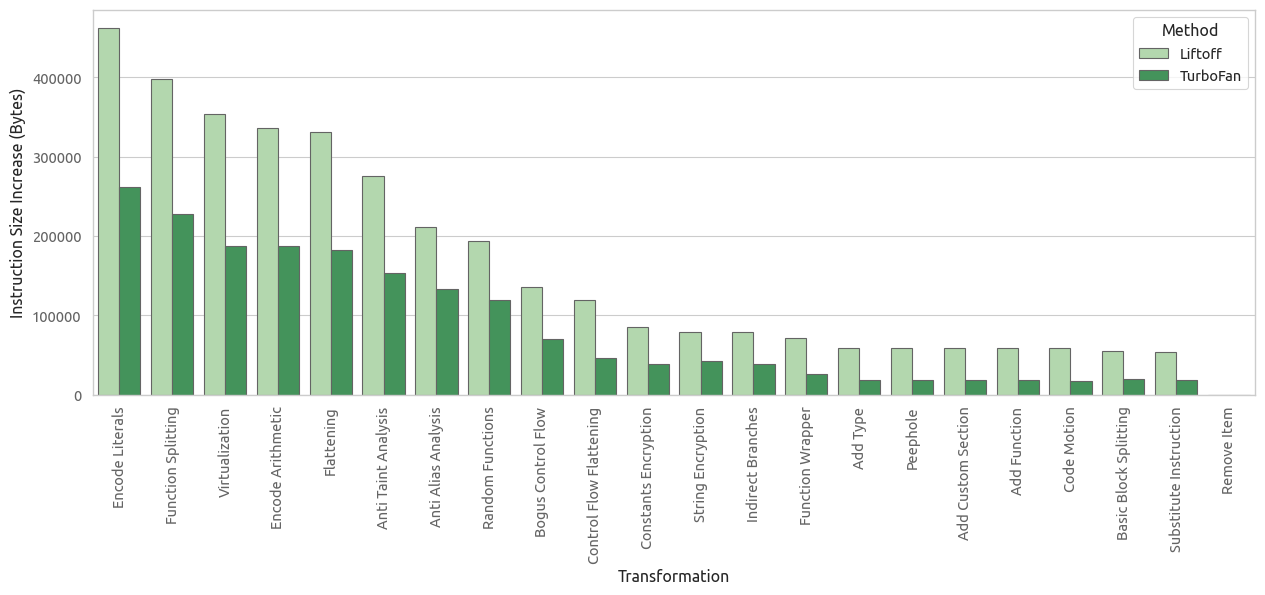

In [13]:
def plot_v8_optimization_by_instruction_increase(df, xlabel, y='increase', palette=None, path=None):
    plt.figure(figsize=(15,5))
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['increase'].mean().reset_index()

    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('increase', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    sorted_df = df.sort_values('increase')

    ax = sns.barplot(data=sorted_df, 
                x='transformation_label', 
                y=y, 
                errorbar=None, 
                hue='stage',
                palette=palette, 
                edgecolor=edgecolor,
                )

    # Axis labels
    plt.ylabel('Instruction Size Increase (Bytes)')
    plt.xlabel(xlabel)
    # plt.ylim(0,3.5)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper right')

    # plt.ylim(0, 2)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

# Concatenate all dataframes in the desired order: tigress, llvm, wasm_mutate
df = pd.concat([tigress_unoptimized, llvm_unoptimized, wasm_mutate_unoptimized_filtered], ignore_index=True)


df_liftoff = df.copy()
df_liftoff['increase'] = df['liftoff_increase']
df_liftoff['stage'] = 'Liftoff'

df_turbofan = df.copy()
df_turbofan['increase'] = df['turbofan_increase']
df_turbofan['stage'] = 'TurboFan'


df = pd.concat([df_liftoff, df_turbofan])
 
plot_v8_optimization_by_instruction_increase(df, "Transformation", y="increase", palette="Greens")

/tmp/ipykernel_10595/4170217346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['liftoff_size'] = df['v8'].apply(lambda x: x['liftoff_size'])
/tmp/ipykernel_10595/4170217346.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['turbofan_size'] = df['v8'].apply(lambda x: x['turbofan_size'])
/tmp/ipykernel_10595/1748718249.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

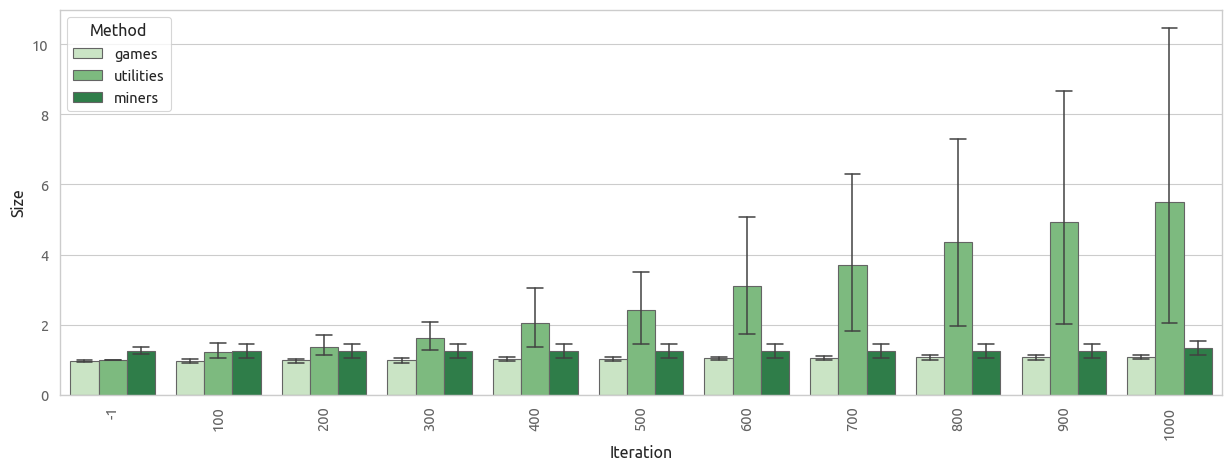

/tmp/ipykernel_10595/1196313163.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transformation_label'] = pd.Categorical(df['transformation_label'],


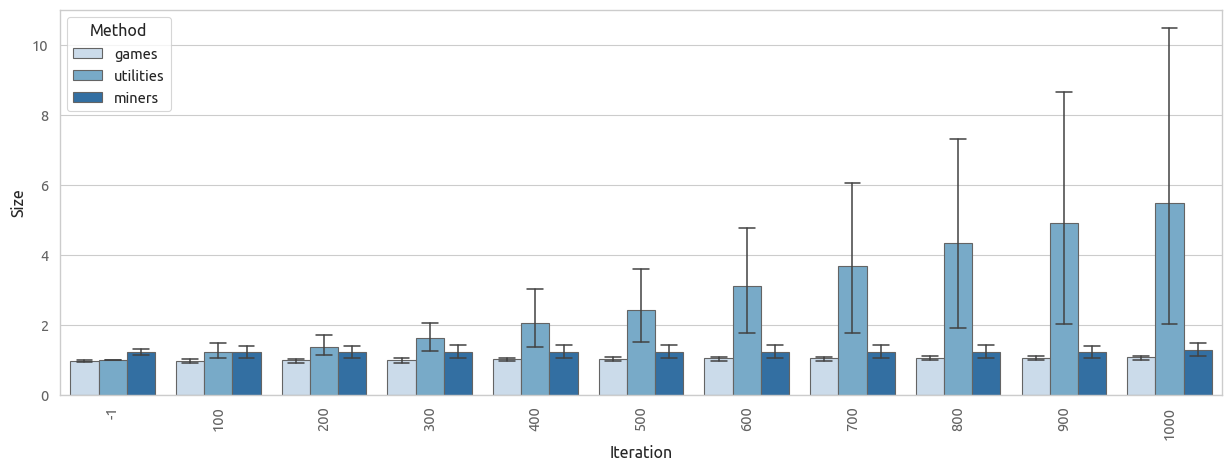

In [14]:
def plot_v8_optimization_by_iteration(df, xlabel, y='liftoff_size', palette=None, path=None):
    plt.figure(figsize=(15,5))
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['distance'].mean().reset_index()

    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('distance', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    sorted_df = df.sort_values('transformation_label')

    sns.barplot(data=sorted_df, 
                x='iteration', 
                y=y, 
                #dodge=False,
                hue='category',
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Size')
    plt.xlabel(xlabel)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper left')

    # plt.ylim(0, 2)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] == -1]
wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized[wasm_mutate_unoptimized['v8'].notnull()]
wasm_mutate_unoptimized_filtered = get_liftoff_and_turbofan_sizes(wasm_mutate_unoptimized_filtered)
wasm_mutate_unoptimized_filtered = compute_relative_sizes(wasm_mutate_unoptimized_filtered, unobfuscated_unoptimized)
wasm_mutate_unoptimized_filtered = compute_instruction_increase(wasm_mutate_unoptimized_filtered, unobfuscated_unoptimized)

df 

plot_v8_optimization_by_iteration(wasm_mutate_unoptimized_filtered, palette="Greens", xlabel="Iteration", y='relative_liftoff_size')
plot_v8_optimization_by_iteration(wasm_mutate_unoptimized_filtered, palette="Blues", xlabel="Iteration", y='relative_turbofan_size')


In [15]:
def plot_v8_optimization_by_iteration(df, xlabel, y='increase', palette=None, path=None):
    plt.figure(figsize=(15,5))
    
    # Compute the average distance for each transformation_label
    avg_distance = df.groupby('transformation_label')['distance'].mean().reset_index()

    # Sort DataFrame by descending values of the average distance
    avg_distance_sorted = avg_distance.sort_values('distance', ascending=False)

    # Use the sorted order to sort the original DataFrame by transformation_label
    df['transformation_label'] = pd.Categorical(df['transformation_label'],
                                                categories=avg_distance_sorted['transformation_label'],
                                                ordered=True)
    
    sorted_df = df.sort_values('transformation_label')

    sns.barplot(data=sorted_df, 
                x='iteration', 
                y=y, 
                #dodge=False,
                hue='category',
                palette=palette, 
                errwidth=1.1, 
                capsize=0.15, 
                edgecolor=edgecolor,
                )
    
    # Axis labels
    plt.ylabel('Increase')
    plt.xlabel(xlabel)

    plt.xticks(rotation=90)

    # Capitalize the first letter of the entries in the legend
    plt.legend(title='Method', loc='upper left')

    plt.ylim(0, 2)

    # Save plot 
    if path is not None: 
        plt.savefig(path, dpi=300, bbox_inches="tight")

    # Show the plot 
    plt.show()

wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized[wasm_mutate_unoptimized['iteration'] != -1]
wasm_mutate_unoptimized_filtered = wasm_mutate_unoptimized_filtered[wasm_mutate_unoptimized_filtered['v8'].notnull()]



wasm_mutate_unoptimized_filtered = get_liftoff_and_turbofan_sizes(wasm_mutate_unoptimized_filtered)
wasm_mutate_unoptimized_filtered = compute_relative_sizes(wasm_mutate_unoptimized_filtered, unobfuscated_unoptimized)
wasm_mutate_unoptimized_filtered = compute_instruction_increase(wasm_mutate_unoptimized_filtered, unobfuscated_unoptimized)

# df = pd.concat([wasm_mutate_unoptimized_filtered, wasm_mutate_unoptimized_filtered])

# plot_v8_optimization_by_iteration(wasm_mutate_unoptimized_filtered, palette="Blues", xlabel="Iteration", y='increase')
wasm_mutate_unoptimized_filtered

,name,file,unobfuscated_file,category,iteration,mutator,code,file_size,virustotal,distance,...,hash_rate,verified_hashes,transformation,transformation_label,liftoff_size,turbofan_size,relative_liftoff_size,relative_turbofan_size,liftoff_increase,turbofan_increase
71,breakout,breakout/wasm-mutate/iteration-100/breakout.wasm,breakout/unobfuscated/breakout.wasm,games,100,CodemotionMutator,0,686176,"{'result': 0, 'last_analysis_stats': {'harmles...",294941.0,...,NaN,NaN,CodemotionMutator,Code Motion,202896,182220,1.016472,1.018376,3288,3288
208,breakout,breakout/wasm-mutate/iteration-200/breakout.wasm,breakout/unobfuscated/breakout.wasm,games,200,AddCustomSectionMutator,0,700688,"{'result': 0, 'last_analysis_stats': {'harmles...",306574.0,...,NaN,NaN,AddCustomSectionMutator,Add Custom Section,203596,182432,1.019979,1.019561,3988,3500
367,breakout,breakout/wasm-mutate/iteration-300/breakout.wasm,breakout/unobfuscated/breakout.wasm,games,300,PeepholeMutator,0,704088,"{'result': 0, 'last_analysis_stats': {'harmles...",310046.0,...,NaN,NaN,PeepholeMutator,Peephole,204312,183148,1.023566,1.023562,4704,4216
384,breakout,breakout/wasm-mutate/iteration-400/breakout.wasm,breakout/unobfuscated/breakout.wasm,games,400,CodemotionMutator,0,710758,"{'result': 0, 'last_analysis_stats': {'harmles...",312779.0,...,NaN,NaN,CodemotionMutator,Code Motion,204976,184176,1.026893,1.029307,5368,5244
463,breakout,breakout/wasm-mutate/iteration-500/breakout.wasm,breakout/unobfuscated/breakout.wasm,games,500,PeepholeMutator,0,719553,"{'result': 0, 'last_analysis_stats': {'harmles...",316970.0,...,NaN,NaN,PeepholeMutator,Peephole,207632,186308,1.040199,1.041222,8024,7376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21738,cn-lite-2,cn-lite-2/wasm-mutate/iteration-600/cn-lite-2....,cn-lite-2/unobfuscated/cn-lite-2.wasm,miners,600,CustomSectionMutator,0,452704,"{'result': 0, 'last_analysis_stats': {'harmles...",178012.0,...,"{'hash_count': [0, 0, 0, 0, 45, 101, 156, 210,...",100.0,CustomSectionMutator,Custom Section,888640,327368,1.652165,1.596356,350776,122296
21823,cn-lite-2,cn-lite-2/wasm-mutate/iteration-700/cn-lite-2....,cn-lite-2/unobfuscated/cn-lite-2.wasm,miners,700,AddCustomSectionMutator,0,555265,"{'result': 0, 'last_analysis_stats': {'harmles...",218322.0,...,"{'hash_count': [0, 0, 0, 0, 48, 108, 166, 225,...",100.0,AddCustomSectionMutator,Add Custom Section,888640,329272,1.652165,1.605641,350776,124200
21928,cn-lite-2,cn-lite-2/wasm-mutate/iteration-800/cn-lite-2....,cn-lite-2/unobfuscated/cn-lite-2.wasm,miners,800,CodemotionMutator,0,576314,"{'result': 0, 'last_analysis_stats': {'harmles...",226415.0,...,"{'hash_count': [0, 0, 0, 0, 50, 110, 169, 227,...",100.0,CodemotionMutator,Code Motion,888640,334724,1.652165,1.632227,350776,129652
22032,cn-lite-2,cn-lite-2/wasm-mutate/iteration-900/cn-lite-2....,cn-lite-2/unobfuscated/cn-lite-2.wasm,miners,900,AddCustomSectionMutator,0,606417,"{'result': 0, 'last_analysis_stats': {'harmles...",237921.0,...,"{'hash_count': [0, 0, 0, 0, 51, 109, 168, 226,...",100.0,AddCustomSectionMutator,Add Custom Section,888640,327368,1.652165,1.596356,350776,122296
